In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy import integrate
import numpy.random as npr
npr.seed(372)
import matplotlib.pyplot as plt
%matplotlib inline

1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method

In [2]:
# Create an array of order N with normal distribution:
mu, sigma = 323, 5
N = 500
x = npr.normal(mu, sigma, N)

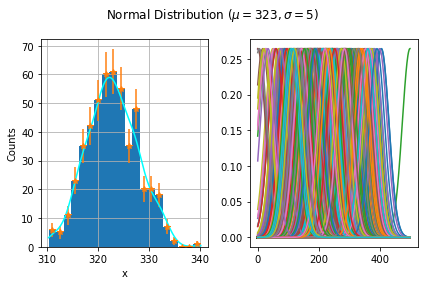

In [3]:
figure, (ax0, ax1) = plt.subplots(nrows=1, ncols=2)

# Histogram with the data
counts, bins, patches = ax0.hist(x, bins=20)

X = [(bins[i+1]+bins[i])/2 for i in range(len(bins)-1)]
unc = [i**(1/2) for i in counts]

ax0.errorbar(X, counts, yerr =unc, fmt = '*')
figure.suptitle('Normal Distribution $(\mu = {}, \sigma = {})$'.format(mu, sigma))
ax0.set_xlabel('x')
ax0.set_ylabel('Counts')
ax0.grid(True)

#Create a gaussian for every element of x

stdev = 1.06*x.std()*x.size**(-1/5)
xaxis = np.linspace(x.min(), x.max(), N)
gaussian = []

for i in x:
    gaussian.append(stats.norm.pdf(xaxis,i,stdev))
    ax1.plot(stats.norm.pdf(xaxis,i,stdev))

# Create the gaussian of the histogram by sum
gauss_tot = np.sum(gaussian, axis = 0)
int1 = integrate.trapz(counts, X)
int2 = integrate.trapz(gauss_tot, xaxis)

gauss_norm = gauss_tot * int1/int2
ax0.plot(xaxis,gauss_norm, color='cyan')
figure.tight_layout()
plt.show()

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

In [4]:
def twocat2D_dataset(mean1, std1, mean2, std2, size):
    data1 = npr.multivariate_normal(mean1, std1, size)
    data2 = npr.multivariate_normal(mean2, std2, size)
    return data1, data2

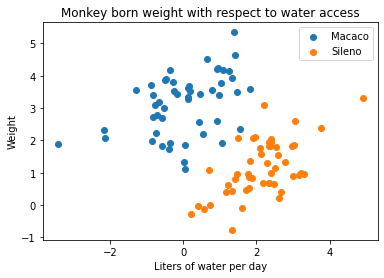

In [5]:
a = np.linspace(2,4,50)
mean1, cov1 = [0, 3], [(1, .3), (.3, 1)]
mean2, cov2 = [2, 1], [(0.8, .5), (.5, 0.8)]
macaco, sileno = twocat2D_dataset(mean1, cov1, mean2, cov2, 50)

plt.scatter(macaco[:,0], macaco[:,1], label='Macaco')
plt.scatter(sileno[:,0], sileno[:,1], label = 'Sileno')
plt.title('Monkey born weight with respect to water access')
plt.ylabel('Weight')
plt.xlabel('Liters of water per day')
plt.legend()
plt.show()

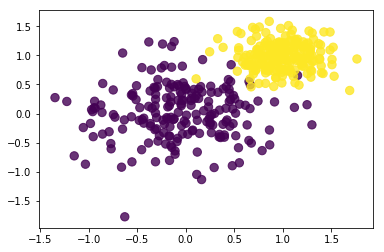

In [6]:
#! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should use the `np.load()` function to load the file as a numpy array, call the `.item()` method, and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

In [7]:
# Load the data
data = np.load('/Users/cmart/Lab of Computational Physics/data/residuals_261.npy', allow_pickle=True).item()
df = pd.DataFrame(data)

# Inspect the features and info
df.dtypes

residuals    float64
distances    float64
dtype: object

In [8]:
# Cleaning of sample, get rid of all residuals higher than 2 in abs value
df = df[abs(df['residuals'])<2]
print(df['residuals'].max(), df['residuals'].min())

1.9928571428571331 -1.9999999999997726


In [9]:
#Linear regression on residuals-distances
reg = stats.linregress(df['residuals'], df['distances'])
print(reg)

LinregressResult(slope=0.577913366635926, intercept=10.025258299436526, rvalue=0.043403510522559086, pvalue=8.717037183576464e-06, stderr=0.1298980963225655, intercept_stderr=0.05919737176060825)


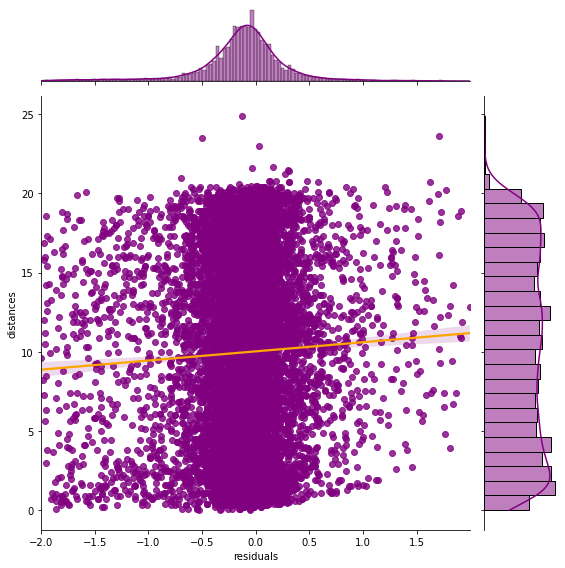

In [10]:
# Some useful arrays
counts_dis ,bins, patches = stats.binned_statistic(df['residuals'], df['distances'], statistic='count', bins = 15, range=(0,20))
x = [(bins[i+1]+bins[i])/2 for i in range(len(bins)-1)]
x.append(bins[15])
df['bins'] = np.digitize(df['distances'], bins)
y = df.groupby(['bins']).mean()['residuals']
erry = df.groupby(['bins']).std()['residuals']

#Plot 
PLT = sns.jointplot(x = 'residuals', y = 'distances', data=df, kind="reg", color='purple', height = 8)
regline = PLT.ax_joint.get_lines()[0]
regline.set_color('orange')